In [1]:
import pandas as pd
import os
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm

from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression

import networkx as nx
 

In [2]:
data_path = r"C:\Projects\connecteddatahub\data"
academic_programs_path = os.path.join(data_path, 'external', 'university_academics_program_percent.csv')
academic_programs_df = pd.read_csv(academic_programs_path)
academic_programs_df['Year'] = academic_programs_df['year']
academic_programs_df['AffiliationSystemId'] = academic_programs_df['AffiliationId']
academic_programs_df.columns

Index(['carnegie_id', 'AffiliationId', 'year',
       'academics.program_percentage.agriculture',
       'academics.program_percentage.resources',
       'academics.program_percentage.architecture',
       'academics.program_percentage.ethnic_cultural_gender',
       'academics.program_percentage.communication',
       'academics.program_percentage.communications_technology',
       'academics.program_percentage.computer',
       'academics.program_percentage.personal_culinary',
       'academics.program_percentage.education',
       'academics.program_percentage.engineering',
       'academics.program_percentage.engineering_technology',
       'academics.program_percentage.language',
       'academics.program_percentage.family_consumer_science',
       'academics.program_percentage.legal',
       'academics.program_percentage.english',
       'academics.program_percentage.humanities',
       'academics.program_percentage.library',
       'academics.program_percentage.biological',
    

In [3]:
grants_path = os.path.join(data_path, 'grants', 'university_grants.csv')
grants_df = pd.read_csv(grants_path)
grants_df["AffiliationSystemId"] = grants_df["SystemId"].combine_first(grants_df["AffiliationId"])
grants_df.columns


# there are duplicates 
def merge_duplicate_grants(df):
    # Define aggregation logic
    agg_dict = {
        "num_grants": "sum",
        "total_funding": "sum",
        "FullName": lambda x: max(x, key=len) if isinstance(x.iloc[0], str) else np.nan
    }

    # For all other columns, just take the first (from the left)
    other_cols = [c for c in df.columns if c not in ["num_grants", "total_funding", "FullName", "AffiliationId", "Year"]]
    for col in other_cols:
        agg_dict[col] = "first"

    # Group and aggregate
    merged_df = (
        df.groupby(["AffiliationId", "Year"], as_index=False)
          .agg(agg_dict)
    )

    return merged_df

grants_df = merge_duplicate_grants(grants_df)



In [4]:
edge_path = os.path.join(data_path, 'interlocks', 'interlock_edges.csv')
node_path = os.path.join(data_path, 'interlocks', 'interlock_nodes.csv')

edge_df = pd.read_csv(edge_path)
node_df = pd.read_csv(node_path)

print(f"Edge df cols: {edge_df.columns}\n")
print(f"Node df cols: {node_df.columns}")

Edge df cols: Index(['Year', 'AffiliationId_1', 'Institution_1', 'AffiliationId_2',
       'Institution_2', 'InterlockCount', 'BoardSize_1', 'BoardSize_2',
       'WeightNorm', 'Weakness', 'Source', 'Target', 'Weight',
       'EdgeEntropyBits'],
      dtype='object')

Node df cols: Index(['Year', 'Id', 'Label', 'SystemId', 'degree', 'degree_centrality',
       'eigenvector_centrality', 'betweenness_centrality', 'clustering',
       'modularity_class', 'interlock_entropy_bits', 'strength', 'Institution',
       'AffiliationId'],
      dtype='object')


In [5]:
node_df["AffiliationId"] = node_df["Id"].astype(str)
grants_df["AffiliationId"] = grants_df["AffiliationId"].astype(str)

# Isolate relevant columns
node_cols = [
    "Year","AffiliationId","SystemId","Label","degree","degree_centrality",
    "eigenvector_centrality","betweenness_centrality","clustering",
    "modularity_class","interlock_entropy_bits","strength"
]

grant_cols = ["AffiliationId","Year","student.size","num_grants","total_funding"]

N = node_df[node_cols].copy()
G = grants_df[grant_cols].dropna(subset=["student.size"]).copy()

interlock_grants_df = N.merge(G, on=["AffiliationId","Year"], how="left")
print(f"Full merged frame: {len(interlock_grants_df):,} rows, {interlock_grants_df['Year'].nunique()} distinct years")

Full merged frame: 1,157 rows, 11 distinct years


In [6]:
def residualize_by_year(df):
    # to control for instiutiton size, regress by year then keep the residuals for the grants
    out = []
    for yr, g in df.groupby("Year"):
        g = g.dropna(subset=["student.size","num_grants","total_funding"]).copy()
        if len(g) < 10:
            continue
        g["log_students"] = np.log1p(g["student.size"])
        g["log_grants"]   = np.log1p(g["num_grants"])
        g["log_funding"]  = np.log1p(g["total_funding"])

        # regress log_grants with log_students
        lr_g = LinearRegression().fit(g[["log_students"]], g["log_grants"])
        g["grants_resid"] = g["log_grants"] - lr_g.predict(g[["log_students"]])

        # regress log_funding with log_students
        lr_f = LinearRegression().fit(g[["log_students"]], g["log_funding"])
        g["funding_resid"] = g["log_funding"] - lr_f.predict(g[["log_students"]])

        out.append(g)
    return pd.concat(out, ignore_index=True)

interlock_grants_resid = residualize_by_year(interlock_grants_df)
print(interlock_grants_resid[["Year","grants_resid","funding_resid"]].groupby("Year").describe().round(2).head())


     grants_resid                                          funding_resid       \
            count mean   std   min   25%   50%   75%   max         count mean   
Year                                                                            
2010         83.0 -0.0  0.93 -2.19 -0.75 -0.05  0.80  1.86          83.0  0.0   
2011         80.0  0.0  1.01 -2.77 -0.71 -0.06  0.86  1.72          80.0 -0.0   
2013         76.0 -0.0  0.97 -2.26 -0.76 -0.00  0.78  1.76          76.0 -0.0   
2018         78.0 -0.0  0.99 -3.70 -0.63  0.01  0.80  1.80          78.0  0.0   

                                          
       std   min   25%   50%   75%   max  
Year                                      
2010  1.67 -3.48 -1.17 -0.00  1.23  4.44  
2011  1.94 -6.60 -1.29  0.30  1.30  4.05  
2013  1.62 -4.47 -1.07  0.42  1.14  4.01  
2018  1.80 -8.22 -0.88  0.28  0.98  4.77  


In [7]:
metrics = [
    "degree","degree_centrality","eigenvector_centrality",
    "betweenness_centrality","clustering","strength","interlock_entropy_bits"
]

corrs = []
for yr, g in interlock_grants_resid.groupby("Year"):
    sub = g[["grants_resid","funding_resid"] + metrics].corr()
    for target in ["grants_resid","funding_resid"]:
        for m in metrics:
            corrs.append({"Year": yr, "target": target, "metric": m, "r": sub.loc[target,m]})
corrs_df = pd.DataFrame(corrs)
pivot = corrs_df.pivot_table(index="Year", columns="metric", values="r")
print(pivot.round(3))


metric  betweenness_centrality  clustering  degree  degree_centrality  \
Year                                                                    
2010                     0.172      -0.099   0.202              0.202   
2011                    -0.050       0.008   0.038              0.038   
2013                     0.146      -0.027   0.233              0.233   
2018                     0.076       0.034   0.146              0.146   

metric  eigenvector_centrality  interlock_entropy_bits  strength  
Year                                                              
2010                    -0.292                   0.208    -0.062  
2011                    -0.096                   0.079    -0.096  
2013                     0.035                   0.201     0.077  
2018                    -0.087                   0.128     0.026  


In [8]:
exposure_list = []

for yr, Eyr in edge_df.groupby("Year"):
    # only keep valid edges
    Eyr = Eyr.dropna(subset=["AffiliationId_1","AffiliationId_2","Weakness"])
    Eyr = Eyr[Eyr["AffiliationId_1"] != Eyr["AffiliationId_2"]]

    # accumulate per node
    node_weak = defaultdict(list)
    for _, row in Eyr.iterrows():
        u, v, w = row["AffiliationId_1"], row["AffiliationId_2"], row["Weakness"]
        node_weak[u].append(w)
        node_weak[v].append(w)

    # compute node-level summaries
    rows = []
    for node, w_list in node_weak.items():
        w_arr = np.array(w_list)
        total_w = w_arr.sum()
        avg_w = w_arr.mean()
        # normalize for entropy
        p = w_arr / w_arr.sum() if w_arr.sum() > 0 else np.full_like(w_arr, 1/len(w_arr))
        entropy = -(p * np.log(p + 1e-12)).sum()  # bits-like heterogeneity
        rows.append({
            "AffiliationId": node,
            "Year": yr,
            "total_weakness": total_w,
            "avg_weakness": avg_w,
            "weakness_entropy": entropy,
            "degree_edges": len(w_arr)
        })

    exposure_list.append(pd.DataFrame(rows))

weak_exposure_df = pd.concat(exposure_list, ignore_index=True)
print(f"Weak exposure table: {len(weak_exposure_df):,} rows, {weak_exposure_df['Year'].nunique()} years")
print(weak_exposure_df.head())

Weak exposure table: 1,103 rows, 11 years
   AffiliationId  Year  total_weakness  avg_weakness  weakness_entropy  \
0           1003  1999        0.161017      0.080508      5.076127e-01   
1      200719446  1999        1.273729      0.318432      1.194776e+00   
2     2799495847  1999        0.161017      0.080508      5.076127e-01   
3         392282  1999        0.463136      0.463136     -1.000089e-12   
4       71965598  1999        0.463136      0.463136     -1.000089e-12   

   degree_edges  
0             2  
1             4  
2             2  
3             1  
4             1  


In [9]:
interlock_grants_df['AffiliationId'] = interlock_grants_df['AffiliationId'].astype(str)
weak_exposure_df['AffiliationId'] = weak_exposure_df['AffiliationId'].astype(str)

#merge resdiuals into the weak exposure df
Z_exposure = interlock_grants_resid.merge(weak_exposure_df, on=["AffiliationId","Year"], how="left")
print(Z_exposure[["Year","avg_weakness","weakness_entropy","grants_resid","funding_resid"]].describe().round(3))


           Year  avg_weakness  weakness_entropy  grants_resid  funding_resid
count   317.000       317.000           317.000       317.000        317.000
mean   2012.940         0.526             0.627        -0.000          0.000
std       3.089         0.166             0.567         0.972          1.753
min    2010.000         0.049            -0.000        -3.695         -8.221
25%    2010.000         0.465            -0.000        -0.736         -1.130
50%    2011.000         0.567             0.692        -0.024          0.280
75%    2013.000         0.631             1.097         0.805          1.098
max    2018.000         0.783             2.034         1.860          4.771


In [10]:
results = []

# go by year and get correlation between weakness + grants
for yr, g in Z_exposure.groupby("Year"):
    corr = g[["avg_weakness","weakness_entropy","grants_resid","funding_resid"]].corr().round(3)
    results.append({
        "Year": yr,
        "r_avgweak_grants": corr.loc["avg_weakness","grants_resid"],
        "r_avgweak_funding": corr.loc["avg_weakness","funding_resid"],
        "r_entropy_grants": corr.loc["weakness_entropy","grants_resid"],
        "r_entropy_funding": corr.loc["weakness_entropy","funding_resid"],
        "n": len(g)
    })

weak_years = pd.DataFrame(results).set_index("Year").sort_index()
print(weak_years)


      r_avgweak_grants  r_avgweak_funding  r_entropy_grants  \
Year                                                          
2010             0.188              0.158             0.264   
2011             0.118              0.018             0.092   
2013             0.016              0.045             0.227   
2018             0.002             -0.015             0.162   

      r_entropy_funding   n  
Year                         
2010              0.184  83  
2011              0.052  80  
2013              0.189  76  
2018              0.095  78  


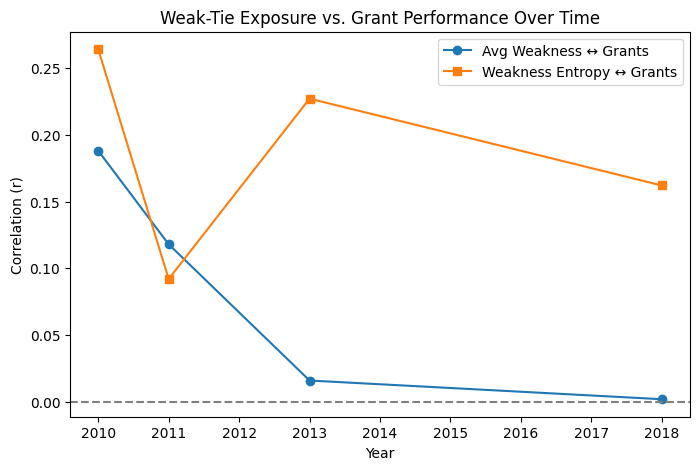

In [11]:
plt.figure(figsize=(8,5))
plt.plot(weak_years.index, weak_years["r_avgweak_grants"], marker="o", label="Avg Weakness ↔ Grants")
plt.plot(weak_years.index, weak_years["r_entropy_grants"], marker="s", label="Weakness Entropy ↔ Grants")
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Year")
plt.ylabel("Correlation (r)")
plt.title("Weak-Tie Exposure vs. Grant Performance Over Time")
plt.legend()
plt.show()

In [12]:
from scipy.stats import pearsonr
import pandas as pd
import numpy as np

results = []

for yr, g in Z_exposure.groupby("Year"):
    g = g[["avg_weakness","weakness_entropy","grants_resid","funding_resid"]].dropna()
    n = len(g)

    def safe_corr(x, y):
        r, p = pearsonr(x, y)
        return r, p

    r1, p1 = safe_corr(g["avg_weakness"], g["grants_resid"])
    r2, p2 = safe_corr(g["avg_weakness"], g["funding_resid"])
    r3, p3 = safe_corr(g["weakness_entropy"], g["grants_resid"])
    r4, p4 = safe_corr(g["weakness_entropy"], g["funding_resid"])

    results.append({
        "Year": yr,
        "r_avgweak_grants": r1,
        "p_avgweak_grants": p1,
        "r_avgweak_funding": r2,
        "p_avgweak_funding": p2,
        "r_entropy_grants": r3,
        "p_entropy_grants": p3,
        "r_entropy_funding": r4,
        "p_entropy_funding": p4,
        "n": n
    })

weak_years = pd.DataFrame(results).set_index("Year").sort_index()
print(weak_years.round(3))


      r_avgweak_grants  p_avgweak_grants  r_avgweak_funding  \
Year                                                          
2010             0.188             0.090              0.158   
2011             0.118             0.299              0.018   
2013             0.016             0.889              0.045   
2018             0.002             0.986             -0.015   

      p_avgweak_funding  r_entropy_grants  p_entropy_grants  \
Year                                                          
2010              0.153             0.264             0.016   
2011              0.877             0.092             0.418   
2013              0.697             0.227             0.048   
2018              0.896             0.162             0.155   

      r_entropy_funding  p_entropy_funding   n  
Year                                            
2010              0.184              0.096  83  
2011              0.052              0.646  80  
2013              0.189              0.101  76

In [13]:
Z_exposure.columns

Index(['Year', 'AffiliationId', 'SystemId', 'Label', 'degree',
       'degree_centrality', 'eigenvector_centrality', 'betweenness_centrality',
       'clustering', 'modularity_class', 'interlock_entropy_bits', 'strength',
       'student.size', 'num_grants', 'total_funding', 'log_students',
       'log_grants', 'log_funding', 'grants_resid', 'funding_resid',
       'total_weakness', 'avg_weakness', 'weakness_entropy', 'degree_edges'],
      dtype='object')

In [ ]:
results = []
for yr, g in Z_exposure.groupby("Year"):
    g = g[["avg_weakness","weakness_entropy","grants_resid","funding_resid"]].dropna()

    rho1, p1 = spearmanr(g["avg_weakness"], g["grants_resid"])
    rho2, p2 = spearmanr(g["avg_weakness"], g["funding_resid"])
    rho3, p3 = spearmanr(g["weakness_entropy"], g["grants_resid"])
    rho4, p4 = spearmanr(g["weakness_entropy"], g["funding_resid"])
    results.append({"Year": yr, "rho_avgweak_grants": rho1, "p": p1,
                    "rho_avgweak_funding": rho2, "p2": p2,
                    "rho_entropy_grants": rho3, "p3": p3,
                    "rho_entropy_funding": rho4, "p4": p4})

spearman_years = pd.DataFrame(results).set_index("Year")
print(spearman_years)


      rho_avgweak_grants         p  rho_avgweak_funding        p2  \
Year                                                                
2010            0.138327  0.212357             0.125236  0.259279   
2011            0.150352  0.183121             0.057493  0.612464   
2013            0.017623  0.879897             0.042232  0.717178   
2018            0.047706  0.678319             0.060287  0.600057   

      rho_entropy_grants        p3  rho_entropy_funding        p4  
Year                                                               
2010            0.254474  0.020256             0.149971  0.175975  
2011            0.141455  0.210714             0.063991  0.572808  
2013            0.218661  0.057738             0.153602  0.185252  
2018            0.206201  0.070104             0.216766  0.056617  


In [15]:
model = smf.ols("grants_resid ~ avg_weakness + weakness_entropy + C(Year)", data=Z_exposure).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           grants_resid   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2.609
Date:                Wed, 12 Nov 2025   Prob (F-statistic):             0.0249
Time:                        15:05:36   Log-Likelihood:                -433.82
No. Observations:                 317   AIC:                             879.6
Df Residuals:                     311   BIC:                             902.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.4430      0.211  

In [ ]:
print(Z_exposure.tail(10))
#filtering out years that are not counted in number of grants
interlock_grants = Z_exposure[Z_exposure['Year'] >= 2010]
interlock_grants.to_csv(os.path.join(data_path, 'interlocks', 'interlocks_grants.csv'), index = False)

     Year AffiliationId  SystemId                             Label  degree  \
307  2018     170201317       NaN          University Of Pittsburgh       6   
308  2018     170897317       NaN                   Duke University       1   
309  2018     178169726       NaN     Southern Methodist University       1   
310  2018     180949307       NaN  Illinois Institute Of Technology       3   
311  2018     184565670       NaN             Georgetown University       3   
312  2018     185071736       NaN                Chapman University       2   
313  2018     186143895       NaN                 Lehigh University       2   
314  2018     200719446       NaN             Vanderbilt University       2   
315  2018     204465549       NaN             Washington University       3   
316  2018     205783295       NaN                Cornell University       3   

     degree_centrality  eigenvector_centrality  betweenness_centrality  \
307           0.066667            4.352149e-01          

In [17]:
interlock_grants.nlargest(10, 'weakness_entropy')

,Year,AffiliationId,SystemId,Label,degree,degree_centrality,eigenvector_centrality,betweenness_centrality,clustering,modularity_class,...,total_funding,log_students,log_grants,log_funding,grants_resid,funding_resid,total_weakness,avg_weakness,weakness_entropy,degree_edges
184,2013,63966007,NaN,Massachusetts Institute Of Technology,8,0.088889,1.619529e-03,0.154902,0.071429,3,...,50735879.0,8.414274,5.365976,17.742144,1.091657,2.151024,4.499107,0.562388,2.033882,8
283,2018,111979921,NaN,Northwestern University,6,0.066667,1.449671e-08,0.081648,0.000000,0,...,183045209.0,9.042158,6.295266,19.025244,1.370587,2.206093,3.965217,0.660870,1.790593,6
106,2011,63966007,NaN,Massachusetts Institute Of Technology,6,0.063158,2.675835e-03,0.243673,0.066667,5,...,208024414.0,8.381144,4.969813,19.153166,1.003974,3.437944,3.602336,0.600389,1.776126,6
201,2013,103531236,NaN,Boston College,6,0.066667,5.041427e-05,0.162938,0.133333,1,...,20633073.0,9.155462,4.700480,16.842406,0.063925,0.463361,3.399107,0.566518,1.765103,6
13,2010,40347166,NaN,University Of Chicago,6,0.061224,2.913209e-03,0.075984,0.200000,0,...,34395832.0,8.567696,5.293305,17.353446,1.479100,2.150216,2.733182,0.455530,1.754167,6
74,2010,184565670,NaN,Georgetown University,6,0.061224,3.167106e-03,0.074122,0.200000,0,...,21888543.0,8.883086,4.779123,16.901474,0.849485,1.411100,2.764545,0.460758,1.743652,6
166,2013,5388228,NaN,University Of Rochester,6,0.066667,2.017866e-04,0.122643,0.133333,2,...,15753780.0,8.707483,5.087596,16.572591,0.669979,0.669773,3.084821,0.514137,1.736385,6
120,2011,102179633,NaN,New School University,6,0.063158,4.551168e-03,0.280534,0.133333,2,...,83000.0,8.829958,1.386294,11.326608,-2.768727,-4.678611,3.130374,0.521729,1.728618,6
121,2011,102179633,NaN,New School,6,0.063158,4.551168e-03,0.280534,0.133333,2,...,83000.0,8.829958,1.386294,11.326608,-2.768727,-4.678611,3.130374,0.521729,1.728618,6
1,2010,1925986,NaN,Loyola University Chicago,6,0.061224,1.884448e-02,0.092826,0.200000,0,...,450747.0,9.247765,2.639057,13.018664,-1.424055,-2.803730,2.940455,0.490076,1.705160,6
